In [1]:
from src.dataset import get_raw_training_data, get_raw_testing_data, get_labels
from src.spacy_helper import format_data_as_spacy_irrelevant, format_data_as_spacy_others, format_data_as_spacy
from src.spacy_helper import get_spacy_irrelevant_model, get_spacy_others_model, train, predict, predict_with_threshold

from src.metrics import score
from src.visualization import plot_confusion_matrix

import numpy as np
import time

In [2]:
raw_training_data = get_raw_training_data('./data/training_set.json')
raw_testing_data = get_raw_testing_data('./data/testing_set.json')

labels = get_labels(raw_training_data)

y_true = [r['intent'] for r in raw_testing_data]
y_true_t = [r['intent'] for r in raw_training_data]

X_train, y_train = format_data_as_spacy_irrelevant(raw_training_data)
X_test, y_test = format_data_as_spacy_irrelevant(raw_testing_data)


irrelevant_model = get_spacy_irrelevant_model(labels)


irrelevant_model = train(irrelevant_model, X_train, y_train, 10, test=(X_test, y_test))
irrelevant_model.to_disk(f"./model")

Training the model...
Iteration 0/10. train_loss: 11.133170923840225 test score:82.53106804677344%
Iteration 1/10. train_loss: 0.6083493212900066 test score:84.18515037593986%
Iteration 2/10. train_loss: 0.12402289156580082 test score:85.55863254392666%
Iteration 3/10. train_loss: 0.040051922307611676 test score:85.82210812642981%
Iteration 4/10. train_loss: 0.01813635577173045 test score:86.38268652475551%
Iteration 5/10. train_loss: 0.013316357902795062 test score:85.69668922963578%
Iteration 6/10. train_loss: 0.011738607981442328 test score:86.77902979373567%
Iteration 7/10. train_loss: 0.01028384957498929 test score:86.42542267424129%
Iteration 8/10. train_loss: 0.008151670967436075 test score:85.42852734631616%
Iteration 9/10. train_loss: 0.007255957997372775 test score:85.97281492018335%


In [3]:
raw_training_data_others = [r for r in raw_training_data if r['intent'] != "irrelevant"]
raw_testing_data_others = [r for r in raw_testing_data if r['intent'] != "irrelevant"]

others_y_true = [r['intent'] for r in raw_testing_data if r['intent'] != "irrelevant"]
others_y_true_t = [r['intent'] for r in raw_training_data if r['intent'] != "irrelevant"]

X_train, y_train = format_data_as_spacy_others(raw_training_data_others)
X_test, y_test = format_data_as_spacy_others(raw_testing_data_others)

others_model = get_spacy_others_model(labels)

others_model = train(others_model, X_train, y_train, 10, test=(X_test, y_test))
others_model.to_disk(f"./model")

Training the model...
Iteration 0/10. train_loss: 18.097669942304492 test score:34.83603039197475%
Iteration 1/10. train_loss: 3.6822757172049023 test score:72.09497719160693%
Iteration 2/10. train_loss: 0.9576395378971938 test score:79.6762963813316%
Iteration 3/10. train_loss: 0.30929219492099946 test score:82.03332946160315%
Iteration 4/10. train_loss: 0.13281982642820367 test score:84.47612395518948%
Iteration 5/10. train_loss: 0.056885817679813044 test score:85.69551661362854%
Iteration 6/10. train_loss: 0.02690934837869463 test score:86.23699671874716%
Iteration 7/10. train_loss: 0.014785852263742072 test score:84.53273197777607%
Iteration 8/10. train_loss: 0.007967020895847554 test score:85.79476606430318%
Iteration 9/10. train_loss: 0.005140096974400876 test score:87.294011362468%


In [4]:
X_train, y_train = format_data_as_spacy(raw_training_data)
X_test, y_test = format_data_as_spacy(raw_testing_data)

y_pred_irr = predict(irrelevant_model, X_test)
y_pred_t_irr = predict(irrelevant_model, X_train)

X_train = [X_train[i] for i in range(len(X_train)) if y_pred_t_irr[i] == 'relevant']
X_test = [X_test[i] for i in range(len(X_test)) if y_pred_irr[i] == 'relevant']

y_pred_oth = predict(others_model, X_test)
y_pred_t_oth = predict(others_model, X_train)
y_pred = []
others_ind = 0
for i in range(len(y_pred_irr)):
    if y_pred_irr[i] == 'irrelevant':
        y_pred.append(y_pred_irr[i])
    else:
        y_pred.append(y_pred_oth[others_ind])
        others_ind += 1


y_pred_t = []
others_ind = 0
for i in range(len(y_pred_t_irr)):
    if y_pred_t_irr[i] == 'irrelevant':
        y_pred_t.append(y_pred_t_irr[i])
    else:
        y_pred_t.append(y_pred_t_oth[others_ind])
        others_ind += 1


In [5]:
testing_results = score(y_true, y_pred)

In [6]:
print(testing_results['report'])

                   precision    recall  f1-score   support

   find-around-me       0.52      0.69      0.59        67
      find-flight       0.75      0.88      0.81        24
       find-hotel       0.67      0.84      0.74        55
  find-restaurant       0.84      0.80      0.82        93
       find-train       0.75      0.86      0.80        21
       irrelevant       0.91      0.88      0.89       677
provide-showtimes       0.67      0.57      0.62        14
         purchase       0.75      0.67      0.71       114

         accuracy                           0.83      1065
        macro avg       0.73      0.77      0.75      1065
     weighted avg       0.84      0.83      0.83      1065



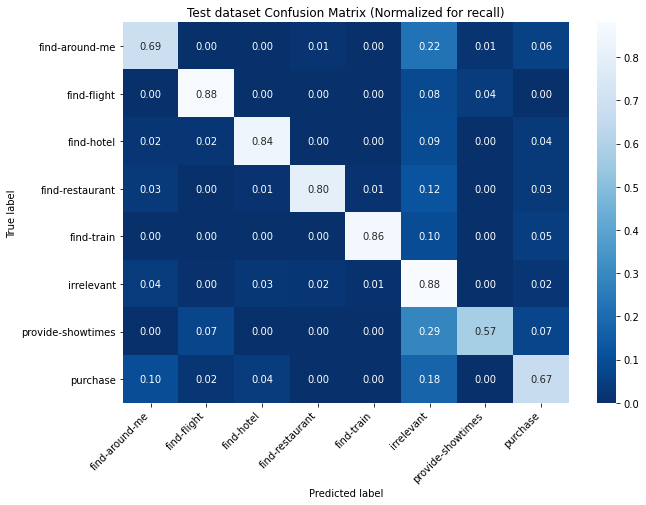

In [7]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

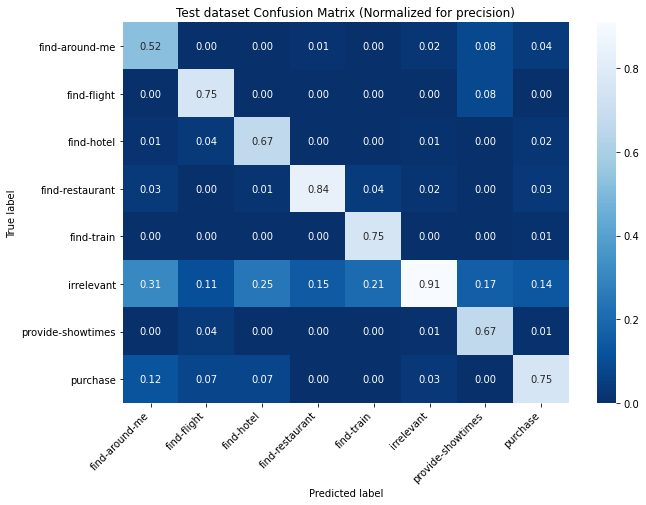

In [8]:
cm_testing_metrics = np.array(testing_results['cm'], dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[:, i] = cm_testing_metrics[:, i] / np.sum(cm_testing_metrics[:,i])
plot_confusion_matrix(cm_testing_metrics, labels, title="Test dataset Confusion Matrix (Normalized for precision)", fmt=".2f")